In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import math
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "data"

# Number of workers for dataloader
workers = 4

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 4

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

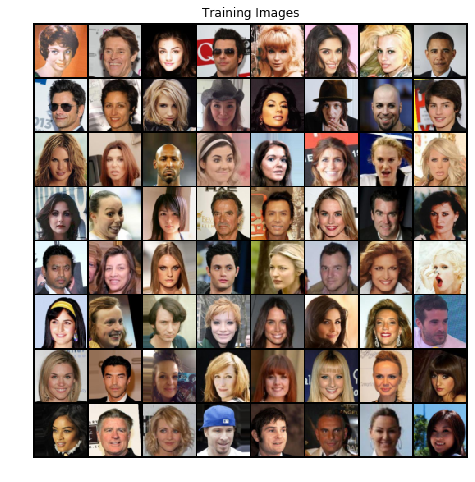

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=workers)



# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class GeneratorLayer(nn.Module):
    def __init__(self, in_channels, out_channels, weights_init, kernel_size, stride, padding):
        super(GeneratorLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [8]:
class ToRGB(nn.Module):
    def __init__(self, in_channels, weights_init, out_channels=3):
        super(ToRGB, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels               = in_channels,
                      out_channels              = out_channels,
                      kernel_size               = 1,
                      stride                    = 1,
                      padding                   = 0,
                      bias                      = False),
            #nn.BatchNorm2d(out_channels),
            nn.Tanh())
        
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_size, in_channels, weights_init, kernel_size=4, stride=2, padding=1):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.weights_init = weights_init
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.layers = nn.ModuleList([])
        self.add_layer(latent_size, self.in_channels)
        self.add_layer()
        
    def add_layer(self, in_channels=None, out_channels=None):
        if not in_channels: in_channels = self.out_channels
        if not out_channels: out_channels = int(in_channels/2)
            
        self.layers.append(GeneratorLayer(in_channels,
                                          out_channels,
                                          self.weights_init,
                                          self.kernel_size,
                                          self.stride,
                                          self.padding).to(device))
        
        self.out_channels = out_channels
        self.toRGB = ToRGB(in_channels=out_channels,
                           weights_init = self.weights_init).to(device)
        
    def forward(self, input, verbose=True):
        if verbose:
            print('Generator forward')
            print('Input shape', input.shape)
            
        x = input
        for layer in self.layers:
            x = layer(x)
            if verbose: print(x.shape)
        x = self.toRGB(x)
        if verbose: print(x.shape)
        return x

Generator forward
Input shape torch.Size([64, 128, 1, 1])
torch.Size([64, 1024, 2, 2])
torch.Size([64, 512, 4, 4])
torch.Size([64, 3, 4, 4])


In [12]:
class FromRGB(nn.Module):
    def __init__(self, out_channels, weights_init, in_channels=3):
        super(FromRGB, self).__init__()
        self.out_channels = out_channels
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [13]:
class DiscriminatorLayer(nn.Module):
    def __init__(self, in_channels, out_channels, weights_init, kernel_size, stride, padding):
        super(DiscriminatorLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer.apply(weights_init)
    def forward(self, input):
        return self.layer(input)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels, weights_init, kernel_size=4, stride=2, padding=1):
        super(Discriminator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weights_init = weights_init
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.layers = nn.ModuleList([])
        self.add_layer(in_channels)
        self.out = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=2, stride=1, padding=0, bias=False).to(device),
            nn.Sigmoid())
        
    def add_layer(self, in_channels):
        self.in_channels = in_channels
        self.layers.insert(0, DiscriminatorLayer(self.in_channels,
                               int(self.in_channels*2),
                               self.weights_init,
                               self.kernel_size,
                               self.stride,
                               self.padding).to(device))
        
        self.fromRGB = FromRGB(self.in_channels, weights_init=self.weights_init).to(device)
        
    def forward(self, input, verbose=True):
        if verbose:
            print('Discriminator forward')
            print('Input shape', input.shape)
            
        
        x = self.fromRGB(input)
        if verbose: print('fromRGB', x.shape)
        for layer in self.layers:
            x = layer(x)
            if verbose: print('layer', x.shape)
        
        x = self.out(x)
        if verbose: print('out', x.shape)
            
        return x

In [15]:
D = Discriminator(G.out_channels, 1024, weights_init)
outD = D(G(fixed_noise, True), True)

Generator forward
Input shape torch.Size([64, 128, 1, 1])
torch.Size([64, 1024, 2, 2])
torch.Size([64, 512, 4, 4])
torch.Size([64, 3, 4, 4])
Discriminator forward
Input shape torch.Size([64, 3, 4, 4])
fromRGB torch.Size([64, 512, 4, 4])
layer torch.Size([64, 1024, 2, 2])
out torch.Size([64, 1, 1, 1])


In [48]:
class ProGAN(nn.Module):
    def __init__(self, ngpu, device, latent_size, in_channels, init_layers,
                 layer_progression, batch_size, weights_init, criterion,
                 verbose=False):
        
        super(ProGAN, self).__init__()
        self.ngpu                    = ngpu
        self.latent_size             = latent_size
        self.layer_progression       = layer_progression
        self.batch_size              = batch_size
        self.criterion               = criterion
        self.device                  = device
        self.generator               = Generator(latent_size,in_channels,weights_init).to(device)
        self.discriminator           = Discriminator(self.generator.out_channels,
                                           self.generator.in_channels,
                                           weights_init).to(device)

        self.optimizerG = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizerD = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
        self.image_size = 4
        
        for i in range(init_layers):
            self.add_layer()
        
    def add_layer(self):
        self.generator.add_layer()
        self.discriminator.add_layer(self.generator.out_channels)
        
        if (self.device.type == 'cuda') and (self.ngpu > 1):
            self.generator = nn.DataParallel(self.generator, list(range(self.ngpu)))
            self.discriminator = nn.DataParallel(self.discriminator, list(range(self.ngpu)))
        
        self.image_size = self.image_size*2
        
    def discriminator_forward(self, data, verbose=False):
        ## Train with REAL batch
        self.discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        self.batch_size = real_cpu.size(0)
        #labels = torch.full((self.batch_size,), self.real_label, device=device)
        labels = torch.FloatTensor(self.batch_size).uniform_(0.0, 0.3).to(device)

        # Forward pass real batch through D
        output = self.discriminator(real_cpu, verbose).view(-1)
        # Calculate loss on all-real batch
        errD_real = self.criterion(output, labels)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        self.D_x = output.mean().item()
        
        
        # Generate batch of latent vectors
        noise = torch.randn(self.batch_size, self.latent_size, 1, 1, device=device)
        # Generate fake image batch with G
        self.fake = self.generator(noise, verbose)
        #labels.fill_(self.fake_label)
        labels = torch.FloatTensor(self.batch_size).uniform_(0.7, 1.0).to(device)
        # Classify all FAKE batch with D
        output = self.discriminator(self.fake.detach(), verbose).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = self.criterion(output, labels)
        # Calculate the gradients for this batch
        errD_fake.backward()
        self.D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        self.errD = errD_real + errD_fake
        # Update D
        self.optimizerD.step()
        
    def generator_forward(self, verbose=True):
        self.generator.zero_grad()
        labels = torch.full((self.batch_size,), 0, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = self.discriminator(self.fake, verbose).view(-1)
        # Calculate G's loss based on this output
        self.errG = self.criterion(output, labels)
        # Calculate gradients for G
        self.errG.backward()
        self.D_G_z2 = output.mean().item()
        # Update G
        self.optimizerG.step()
        
    def forward(self, data, verbose=False):
        self.discriminator_forward(data, verbose)
        self.generator_forward(verbose)

In [51]:
proGAN = ProGAN(
    ngpu                  = 1,
    device                = device,
    latent_size           = 128,
    in_channels           = 512,
    init_layers           = 3,
    layer_progression     = 0,
    batch_size            = 128,
    weights_init          = weights_init,
    criterion             = nn.BCELoss()
)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, proGAN.latent_size, 1, 1, device=device)
outD = proGAN.discriminator(proGAN.generator(fixed_noise, True), True)

Generator forward
Input shape torch.Size([64, 128, 1, 1])
torch.Size([64, 512, 2, 2])
torch.Size([64, 256, 4, 4])
torch.Size([64, 128, 8, 8])
torch.Size([64, 64, 16, 16])
torch.Size([64, 32, 32, 32])
torch.Size([64, 3, 32, 32])
Discriminator forward
Input shape torch.Size([64, 3, 32, 32])
fromRGB torch.Size([64, 32, 32, 32])
layer torch.Size([64, 64, 16, 16])
layer torch.Size([64, 128, 8, 8])
layer torch.Size([64, 256, 4, 4])
layer torch.Size([64, 512, 2, 2])
out torch.Size([64, 1, 1, 1])


Starting Training Loop...
[0/4][0/396]	Loss_D: 1.4665	Loss_G: 1.2131	D(x): 0.5004	D(G(z)): 0.4624 / 0.6927
[0/4][50/396]	Loss_D: 0.8617	Loss_G: 1.9220	D(x): 0.1419	D(G(z)): 0.8402 / 0.8462
[0/4][100/396]	Loss_D: 0.9165	Loss_G: 1.9687	D(x): 0.2205	D(G(z)): 0.9318 / 0.8557
[0/4][150/396]	Loss_D: 0.9198	Loss_G: 3.3124	D(x): 0.1142	D(G(z)): 0.7241 / 0.9617
[0/4][200/396]	Loss_D: 0.8609	Loss_G: 2.3950	D(x): 0.1620	D(G(z)): 0.8020 / 0.9065
[0/4][250/396]	Loss_D: 0.8778	Loss_G: 2.0101	D(x): 0.1593	D(G(z)): 0.8494 / 0.8634
[0/4][300/396]	Loss_D: 0.8897	Loss_G: 1.6785	D(x): 0.1957	D(G(z)): 0.8921 / 0.8090
[0/4][350/396]	Loss_D: 0.8625	Loss_G: 2.4960	D(x): 0.1415	D(G(z)): 0.7948 / 0.9086


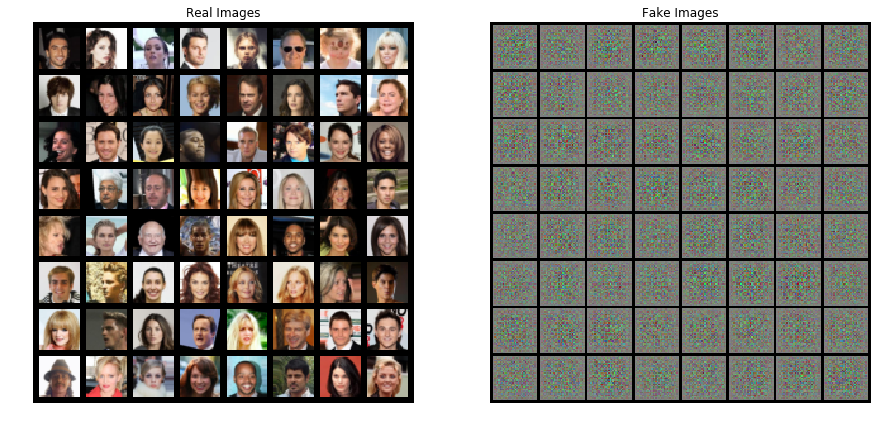

[1/4][0/396]	Loss_D: 0.8915	Loss_G: 2.0750	D(x): 0.2081	D(G(z)): 0.9090 / 0.8712
[1/4][50/396]	Loss_D: 0.8694	Loss_G: 2.6232	D(x): 0.1309	D(G(z)): 0.7954 / 0.9150
[1/4][100/396]	Loss_D: 0.8947	Loss_G: 1.8998	D(x): 0.2104	D(G(z)): 0.8988 / 0.8478
[1/4][150/396]	Loss_D: 0.8658	Loss_G: 2.3090	D(x): 0.1791	D(G(z)): 0.8106 / 0.8849
[1/4][200/396]	Loss_D: 0.8557	Loss_G: 2.0195	D(x): 0.1662	D(G(z)): 0.8172 / 0.8657
[1/4][250/396]	Loss_D: 0.8574	Loss_G: 1.8870	D(x): 0.1563	D(G(z)): 0.8274 / 0.8415
[1/4][300/396]	Loss_D: 0.8712	Loss_G: 2.1055	D(x): 0.1763	D(G(z)): 0.8289 / 0.8717
[1/4][350/396]	Loss_D: 0.8693	Loss_G: 2.3871	D(x): 0.1364	D(G(z)): 0.8042 / 0.9024


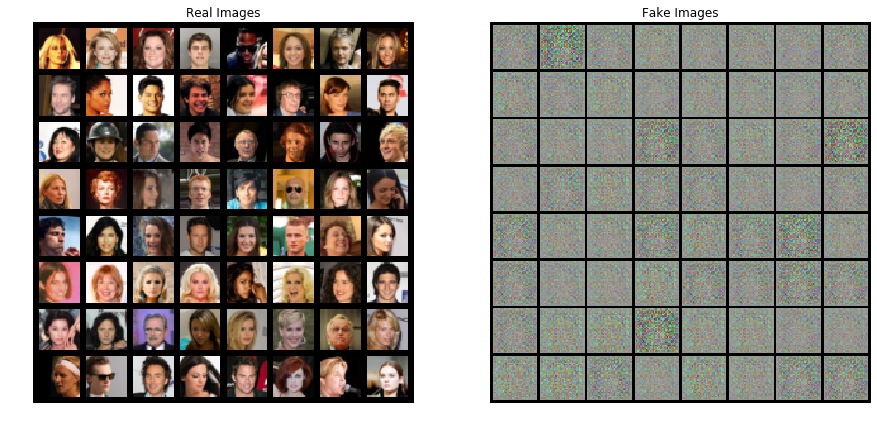

[2/4][0/396]	Loss_D: 0.8743	Loss_G: 1.7800	D(x): 0.1338	D(G(z)): 0.8289 / 0.8215


KeyboardInterrupt: 

In [50]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for j in range(proGAN.layer_progression+1):
    
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(proGAN.image_size),
                                   transforms.CenterCrop(proGAN.image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=proGAN.batch_size,
                                             shuffle=True, num_workers=workers)

    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

    for epoch in range(num_epochs):
        # For each batch in the dataloader

        for i, data in enumerate(dataloader, 0):
            proGAN(data, False)

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         proGAN.errD.item(), proGAN.errG.item(), proGAN.D_x, proGAN.D_G_z1, proGAN.D_G_z2))

            # Save Losses for plotting later
            G_losses.append(proGAN.errG.item())
            D_losses.append(proGAN.errD.item())
            
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = proGAN.generator(fixed_noise, False).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
            iters += 1
        # Grab a batch of real images from the dataloader
        real_batch = next(iter(dataloader))

        # Plot the real images
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.axis("off")
        plt.title("Real Images")
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

        # Plot the fake images from the last epoch
        plt.subplot(1,2,2)
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.show()
    
    #progGAN.add_layer()
    #num_epochs = num_epochs*2
    
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    


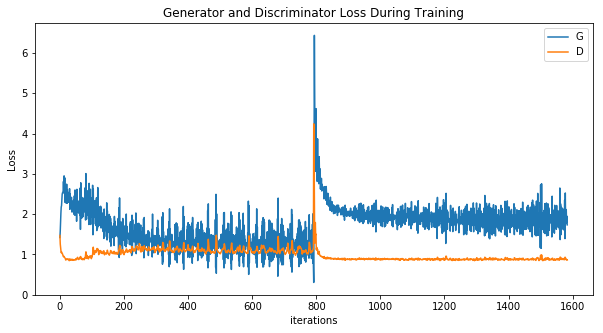

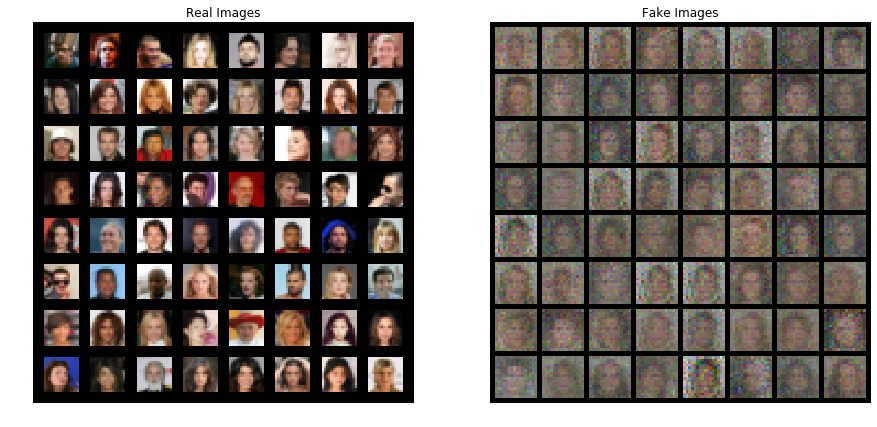

In [24]:
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(dataloader))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()

In [146]:
print(real_batch)
#print(img_list[-1])

[tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.6706, -0.6000, -0.6471,  ..., -0.9922, -1.0000, -1.0000],
          [ 0.1843, -0.2392, -0.3412,  ..., -0.9529, -1.0000, -1.0000],
          [-0.3882, -0.4510, -0.4353,  ..., -0.5686, -0.9294, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.6627, -0.5765, -0.6314,  ..., -0.9922, -1.0000, -1.0000],
          [ 0.2235, -0.1922, -0.3020,  ..., -0.9529, -1.0000, -1.0000],
          [-0.3333, -0.4118, -0.3725,  ..., -0.5686, -0.9294, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, 